In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import os
import seaborn as sns


# set the legend frame
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.edgecolor'] = 'black'
plt.rcParams['legend.framealpha'] = 1

# set the line width
plt.rcParams['lines.linewidth'] = 2.0

# set the point size
plt.rcParams['lines.markersize'] = 8

# set the error bar capsize
plt.rcParams['errorbar.capsize'] = 5

# set the font size
plt.rcParams['font.size'] = 16

# set the figure dpi
plt.rcParams['figure.dpi'] = 192

# set the save figure format
plt.rcParams['savefig.format'] = 'pdf'

sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("paper")


In [ ]:
targets = ["llvm", "opencl", "cuda"]
networks = ["mlp", "mlp_conv", "separable_conv1d", "separable_conv2d", "mlp_wide", "mlp_deep", "mlp_deep_wide", "conv1d", "conv2d", "depthwise_conv1d", "lstm", "mlp_piecewise", "mlp_piecewise2", "mlp_big", "mlp_small"]
old_cluster = 7476309 
version = "0.0.1"
old_cluster2 = 7473667
versions = ["0.0.0", "0.1.0", "0.1.1", "0.0.1"]
old_cluster2s = [7473664,7473665,7473666,7473667]
if version[2] == "0":
    windowsize = 3
else:
    windowsize = 4

In [3]:
best = []
beststd = []
fpga = []
for i, network in enumerate(networks):
    fig , ax = plt.subplots(figsize=(10, 6))
    for j, target in enumerate(targets):
        files = glob.glob(f'../../final/benchmarks/{network}-*{version}-{target}-{old_cluster}*d.perf')
        if files == []:
            best.append(np.nan)
            beststd.append(np.nan)
            continue
        #files = glob.glob(f'../../final/benchmarks/{network}-*-{target}-{old_cluster}*d.perf')
        #print(files)
        batch_size = []
        data = []
        for file in files:
            data.append(np.loadtxt(file, delimiter=','))
            #print(f"Loaded {file}")
            batch_size.append(int(re.findall(r'-\d+', file)[0][1:]))
            #print(f"Batch size {batch_size[-1]}")
        me = np.array([np.mean(d) for d in data])
        st = np.array([np.std(d) for d in data])
        batch_size = np.array(batch_size)
        ax.errorbar(batch_size, me/batch_size*1e6, yerr=st/batch_size*1e6, fmt=['s', 'o', '*'][j], label=target)
        # Make best of each target in a box and place it at 10 and bachsize of 4096
        ax.text(4096, np.exp(j*0.35+1), fr"{target}: {np.amin(me/batch_size*1e6):.2f} $\mu$ s", ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', alpha=1))
        best.append(np.amin(me/batch_size*1e6))
        beststd.append((st/batch_size*1e6)[np.argmin(me/batch_size*1e6)])
        print(f"Best {np.amin(me/batch_size*1e6)} with std {(st/batch_size*1e6)[np.argmin(me/batch_size*1e6)]} for {network} {target}")
    if os.path.exists(f"hls4ml/{network}_{version}_{old_cluster2}_hls4ml_prj/myproject_prj/solution1/syn/report/myproject_csynth.rpt"):
        hls4ml_rpt = f"hls4ml/{network}_{version}_{old_cluster2}_hls4ml_prj/myproject_prj/solution1/syn/report/myproject_csynth.rpt"
        # Find the max latency
        with open(hls4ml_rpt) as f:
            for j, line in enumerate(f):
                if "+ Latency:" in line:
                    # Get the latency 5 lines down
                    print(f"Found latency in {hls4ml_rpt}")
                    for _ in range(6):
                        line = next(f)
                    latency = re.findall(r'\d+', line)[-1]
                    ax.plot([0,65565], [int(latency)*5e-9*1e6, int(latency)*5e-9*1e6], 'r', label="FPGA")
                    ax.text(4096, np.exp(3*0.35+1), fr"FPGA: {int(latency)*5e-9*1e6:.2f} $\mu$ s", ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', alpha=1))
                    fpga.append(int(latency)*5e-9*1e6)
    else:
        fpga.append(np.nan)
    #ax.plot(batch_size, np.ones_like(batch_size)*44*5e-9, 'r', label="FPGA")
    title = f"{network} performance for window size of {windowsize}" + (" inside-out" if version[-1] == "0" else " outside-in") +  (" with float32" if old_cluster == 7476308 else " with float16")
    ax.set_title(title)
    ax.set_xlim(0.6, 50000)
    ax.legend()
    ax.set_xlabel("Batch size")
    ax.set_ylabel(r"Time per sample ($\mu$s)")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True)
    plt.tight_layout()
    #plt.show()
    if old_cluster == 7476308:
        plt.savefig(f"../../final/runtime/{network}_runtime_{version}.pdf")
    else:
        plt.savefig(f"../../final/runtime/{network}_runtime_{version}_fp16.pdf")
    plt.close()



Best 0.17256439775494015 with std 0.006724270653544412 for mlp llvm
Best 0.08942241855197483 with std 2.036076728833837e-05 for mlp opencl
Best 0.08779220370186701 with std 1.8907673403538627e-05 for mlp cuda
Found latency in hls4ml/mlp_0.0.1_7473667_hls4ml_prj/myproject_prj/solution1/syn/report/myproject_csynth.rpt
Best 0.6919943252740143 with std 0.013716757530579927 for mlp_conv llvm
Best 0.11232642118880297 with std 0.004488337442522821 for mlp_conv opencl
Best 0.11451372816721599 with std 0.0031119077093760376 for mlp_conv cuda
Found latency in hls4ml/mlp_conv_0.0.1_7473667_hls4ml_prj/myproject_prj/solution1/syn/report/myproject_csynth.rpt
Best 0.2754987154722214 with std 0.006830606425691582 for separable_conv1d llvm
Best 0.0861513239732018 with std 0.0029257471771888775 for separable_conv1d opencl
Best 0.08481463894555744 with std 0.0029408293952673885 for separable_conv1d cuda
Best 0.4796655317687989 with std 0.008846418518670966 for separable_conv2d llvm
Best 0.104939467209460

/tmp/ipykernel_16139/3159600873.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(networks, rotation=45, ha="right")


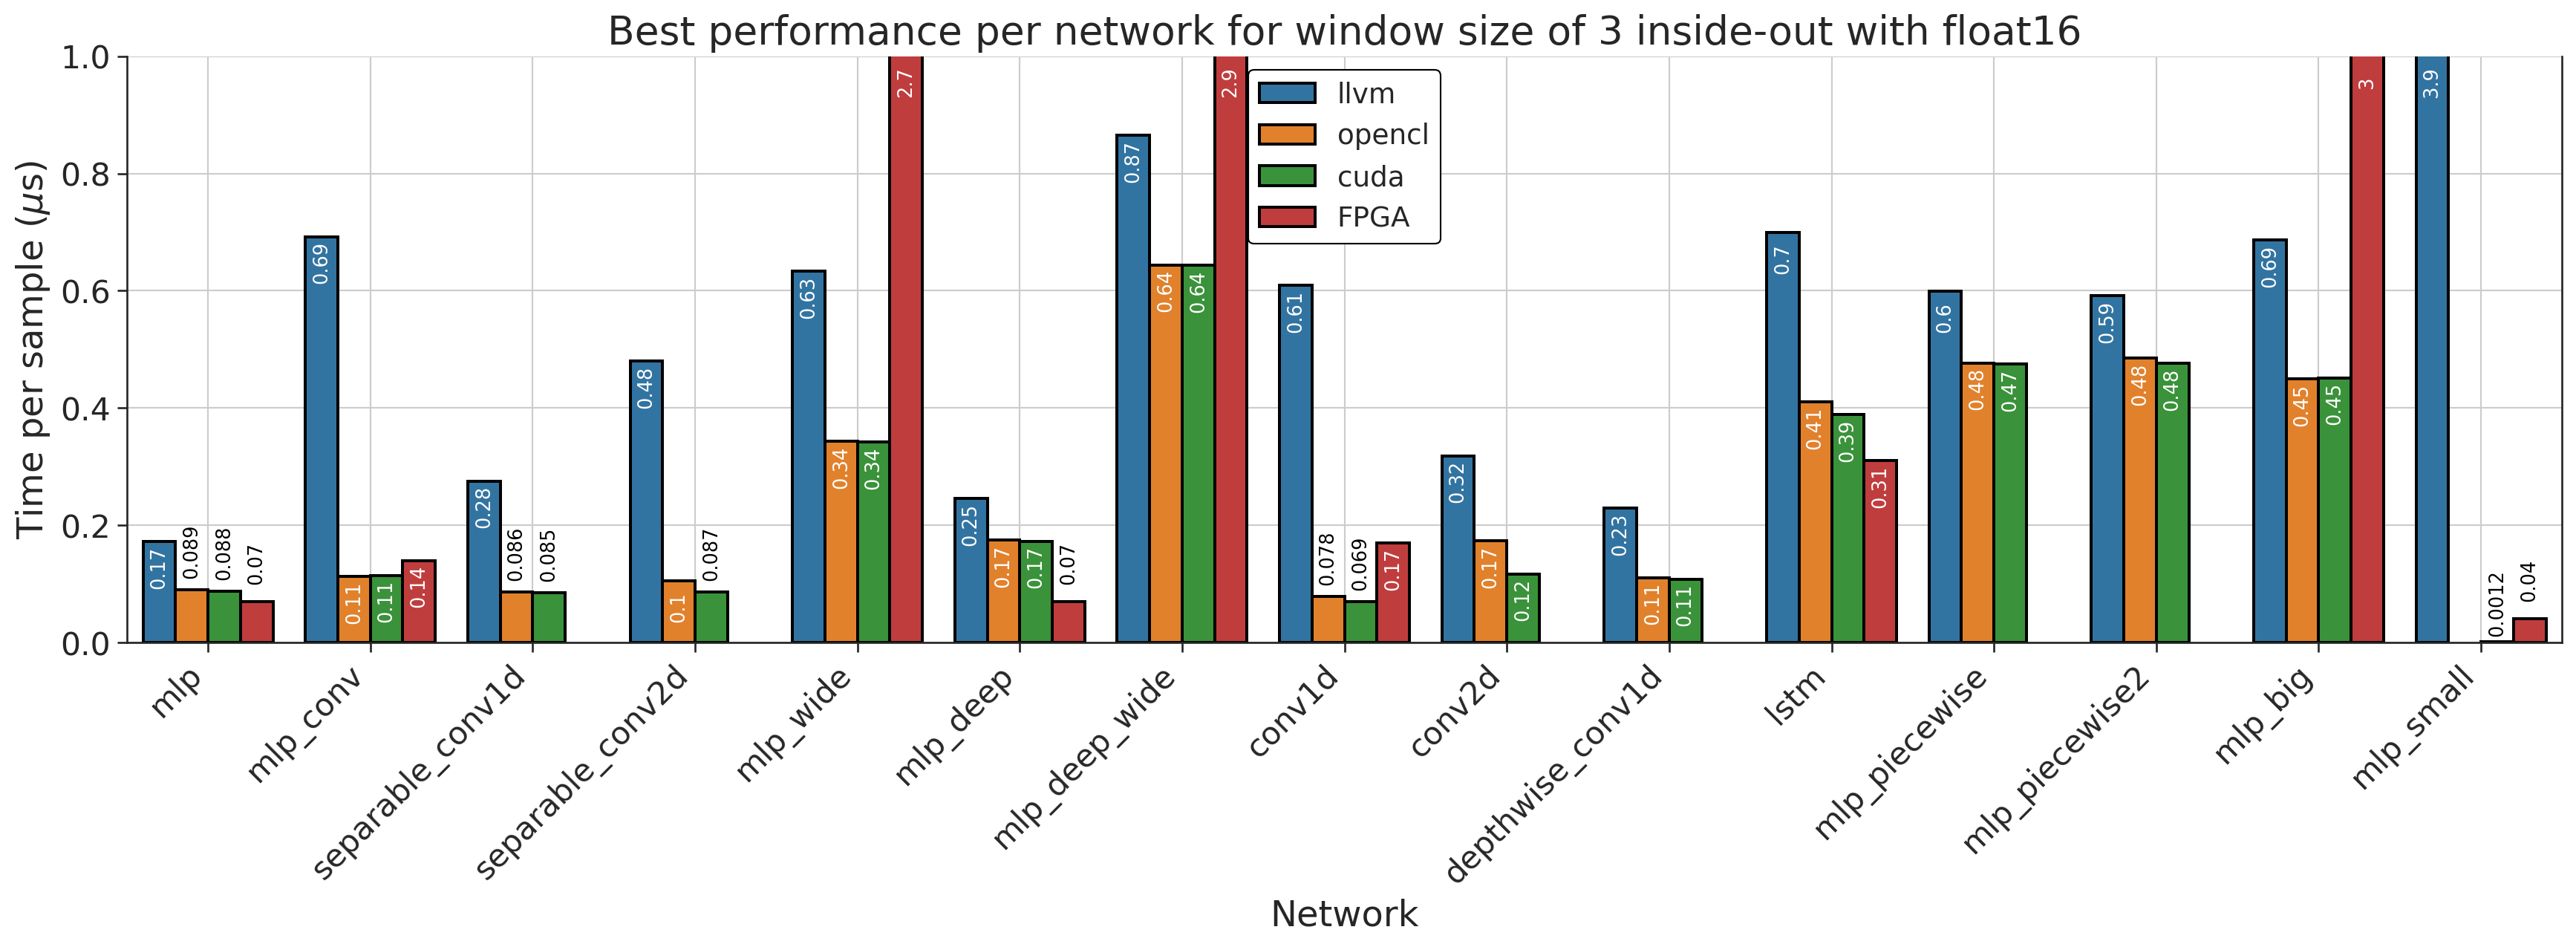

In [39]:
#make a bar plot of the stds using seaborn
import pandas as pd
def custom_errorbar(data):
    return data['STD']
data = []
for i, network in enumerate(networks):
    for j, target in enumerate(targets):
        if np.isnan(best[i*3+j]):
            continue
        data.append([network, target, best[i*3+j], beststd[i*3+j]])
    if not np.isnan(fpga[i]):
        data.append([network, "FPGA", fpga[i], 0])
df = pd.DataFrame(data, columns=['Network', 'Target', 'Time', 'sd'])
fig, ax = plt.subplots(1, figsize=(18, 6))
sns.barplot(df, x="Network", y="Time", ax=ax, errorbar='sd', linewidth=1.5, edgecolor="black", hue="Target")
ax.set_title(f"Best performance per network for window size of {windowsize}"+ (" inside-out" if version[2] == "0" else " outside-in") + (" with float32" if old_cluster == 7476308 else " with float16"), fontsize=20)
ax.set_xlabel("Network", fontsize=18)
ax.set_ylabel(r"Time per sample ($\mu$s)", fontsize=18)
ax.set_xticklabels(networks, rotation=45, ha="right")
ax.grid()
for p in ax.patches:
    if not p.get_height() and not p.get_x() and not p.get_width():
        continue
    ax.annotate(format(p.get_height(), '.2g'), 
                (p.get_x() + p.get_width() / 2., np.amin([p.get_height(),1])-0.01 if p.get_height() > 0.1 else p.get_height()+0.1), 
                ha = 'center', va = 'center', 
                xytext = (0, -10), 
                textcoords = 'offset points',
                color='white' if p.get_height()>0.1 else 'black', rotation=90)
plt.tight_layout()
# set the size of the labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=14)
sns.despine(top=True, right=False)
ax.set_ylim(0,1)
plt.show()
if old_cluster == 7476308:
    plt.savefig(f"../../final/runtime/best_performance_{version}.pdf", bbox_inches='tight')
else:
    plt.savefig(f"../../final/runtime/best_performance_{version}_fp16.pdf", bbox_inches='tight')
plt.close()


